#Il faut adapter ce code pour le faire tourner sur votre machine notamment pour l'emplacement du dataset MNIST

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import copy
import matplotlib.ticker as ticker
import time
import pandas as pd 
import numpy as np
import random
import time
import subprocess
from collections import namedtuple,defaultdict
import matplotlib.pyplot as plt 
import logging
import json
import os
import yaml
import gym
import sys
import threading
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
%load_ext tensorboard


In [ ]:
path_data = '/content/drive/MyDrive/Projet_OCO/data/'

In [ ]:
mnist_train = pd.read_csv(path_data+"mnist_train.csv",header=None)
mnist_test = pd.read_csv(path_data+"mnist_test.csv",header=None)

y_train = mnist_train.loc[:,0].to_numpy()
y_test = mnist_test.loc[:,0].to_numpy()
X_train = mnist_train.loc[:,1:].to_numpy()
X_test = mnist_test.loc[:,1:].to_numpy()


# normalisation
X_train = X_train/255.
X_test = X_test/255.

# 0 vs others

y_train = 2 * (y_train == 0) - 1
y_test = 2 * (y_test == 0) - 1


# Vector preparation : on rajoute une ligne de 1 pour ne pas avoir a expliciter le biais
X_train = np.concatenate([X_train, np.ones((len(X_train), 1))], axis=1)
X_test = np.concatenate([X_test, np.ones((len(X_test), 1))], axis=1)

#UTILS

In [ ]:
#A mettre dans un fichier.py
#Utiliser tensorboard pour avoir une visualisation sur l'evolution de toute nos variables 

import time
import subprocess
from collections import namedtuple,defaultdict
import logging
import json
import os
import yaml
import gym
import sys
import threading
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
%load_ext tensorboard

def loadTensorBoard(outdir):
    t = threading.Thread(target=launchTensorBoard, args=([outdir]))
    t.start()

def launchTensorBoard(tensorBoardPath):
    print('tensorboard --logdir=' + tensorBoardPath)
    ret=os.system('tensorboard --logdir='  + tensorBoardPath)
    if ret!=0:
        syspath = os.path.dirname(sys.executable)
        print(os.path.dirname(sys.executable))
        ret = os.system(syspath+"/"+'tensorboard --logdir=' + tensorBoardPath)
    return


class LogMe(dict):
    def __init__(self,writer,term=True):
        self.writer = writer
        self.dic = defaultdict(list)
        self.term = term
    def write(self,i):
        if len(self.dic)==0: return
        s=f"Epoch {i} : "
        for k,v in self.dic.items():
            self.writer.add_scalar(k,sum(v)*1./len(v),i)
            s+=f"{k}:{sum(v)*1./len(v)} -- "
        self.dic.clear()
        if self.term: logging.info(s)
    def update(self,l):
        for k,v in l:
            self.add(k,v)
    def direct_write(self,k,v,i):
        self.writer.add_scalar(k,v,i)
    def add(self,k,v):
        self.dic[k].append(v)




def prs(*args):
    st = ""
    for s in args:
        st += str(s)
    print(st)


class DotDict(dict):
    """dot.notation access to dictionary attributes (Thomas Robert)"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


def load_yaml(path):
    with open(path, 'r') as stream:
        opt = yaml.load(stream,Loader=yaml.Loader)
    return DotDict(opt)

def write_yaml(file,dotdict):
    d=dict(dotdict)
    with open(file, 'w', encoding='utf8') as outfile:
        yaml.dump(d, outfile, default_flow_style=False, allow_unicode=True)


def init(algoName,
         #config_file,
         ):
    #config = load_yaml(config_file)
    

    now = datetime.now()
    date_time = now.strftime("%d-%m-%Y-%HH%M-%SS")
    outdir = "./XP/" + algoName + "_" + date_time

    print("Saving in " + outdir)
    os.makedirs(outdir, exist_ok=True)
    #save_src(os.path.abspath(outdir))
    #write_yaml(os.path.join(outdir, 'config.yaml'), config)
    logger = LogMe(SummaryWriter(outdir))
    loadTensorBoard(outdir)

    return outdir, logger #config_file, 


def Logger(logger,loss,train_err,test_err,t,eta_t=None):

  logger.direct_write('Loss',loss,t)
  logger.direct_write('Train/Error',train_err,t)
  logger.direct_write('Test/Error',test_err,t)
  if eta_t is not None:
    logger.direct_write('Eta',eta_t,t)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import time 
def time_it(function):
    def wrapper(*args,**kwargs):
        begin = time.time()
        result = function(*args,**kwargs)
        end = time.time()
        print("\n"+function.__name__ + " a mis : {} ms".format((end-begin)*1000))
        return result, (end-begin)*1000
    return wrapper


def reg_hinge_loss(a,b,x,alpha=0,direction=None,test=False): #fourni la loss regularisé,le gradient et l'accuracy
    batch_size = len(b)
    n,d = a.shape
    #Loss
    product = a.dot(x)
    margin = 1 - b*product
    loss = np.maximum(np.zeros(batch_size), margin).mean() + 0.5 * alpha * x.dot(x)
    #Grad
    mask = (margin>0)
    if(test==True):
      grad=0
    else:
      if(direction==None):
        grad = -(1/n)*(mask*b).dot(a) + alpha*x
      else:
        grad = (-(mask*b)*a[0,direction] + alpha*x[direction])[0]
    #Accuracy
    predict = np.sign(product)
    correct = np.sum(b == predict)
    accuracy =  correct / batch_size
    return loss, grad, accuracy


def simplex_proj(x):
    x_s = np.sort(x, kind='quicksort')[::-1]
    cum_s = np.cumsum(x_s)
    res = x_s - (cum_s-1)/(np.arange(len(x))+1)
    d0 = np.max(np.where(res>0)[0]) + 1
    theta = (cum_s[d0-1] -1)/d0

    return np.maximum(0,x-theta),d0,theta

def weighted_simplex_proj(x,D):
    """
    x : vector, D : diag matrix
    """
    dx = np.abs(np.dot(D,x))
    sorted_indices = np.argsort(-dx, kind='quicksort')
    sx = np.cumsum(x[sorted_indices])
    sd = np.cumsum(1/np.diag(D)[sorted_indices])
    res = dx[sorted_indices] - (sx-1)/sd
    d0 = np.max(np.where(res>0)[0])
    theta = (sx[d0]-1)/sd[d0]

    return np.dot(np.diag(1/np.diag(D)),np.maximum(0,dx-theta)),d0,theta

def l1_ball_proj(x,z=1,D=None):
    if sum(abs(x)) <= z:
        return x
    else:
        if D is not None:
            w,d0,theta = weighted_simplex_proj(abs(x)/z,D)
        else :
            w,d0,theta = simplex_proj(abs(x)/z)
        return z*np.sign(x)*w

#ALGOS

In [ ]:
@time_it
def GD(a, b, a_test, b_test, T, alpha): #771142.6951885223 ms environ 12,85min
    n, d = a.shape

    # the weights of our SVM classifier
    x = np.zeros(d)
    
    errors_test = np.zeros(T)
    outdir,logger = init("GD")
    for t in tqdm(range(1, T + 1)):
      if alpha == 0:
          eta_t = 1 / np.sqrt(t)
      else:
          eta_t = 1 / (alpha * t)
      l_train, grad, acc_train = reg_hinge_loss(a,b,x,alpha)
      l_test, _, acc_test = reg_hinge_loss(a_test,b_test,x,alpha,test=True)
      errors_test[t-1] = 1-acc_test
      Logger(logger,
            l_train,
            1-acc_train,
            1-acc_test,
            t,
            eta_t)
      x -= eta_t * grad
    return outdir,errors_test


@time_it
def GDproj(a, b, a_test, b_test, T, alpha,radius): #767956.4852714539ms environ 12,8 min
    n, d = a.shape

    # the weights of our SVM classifier
    x = np.zeros(d)
    errors_test = np.zeros(T)
    outdir,logger = init("GDproj")
    for t in tqdm(range(1, T + 1)):
      if alpha == 0:
          eta_t = 1 / np.sqrt(t)
      else:
          eta_t = 1 / (alpha * t)
      l_train, grad, acc_train = reg_hinge_loss(a,b,x,alpha)
      l_test, _, acc_test = reg_hinge_loss(a_test,b_test,x,alpha,test=True)
      errors_test[t-1] = 1-acc_test
      Logger(logger,
            l_train,
            1-acc_train,
            1-acc_test,
            t,
            eta_t)
      x -= eta_t * grad
      x = l1_ball_proj(x,radius)
    return outdir,errors_test

In [ ]:
@time_it
def SGD(a, b, a_test, b_test, T, alpha): #79208.90021324158 ms environ 1,3min
    np.random.seed(42)
    n, d = a.shape
    
    x = np.zeros(d)
    x_avg = np.zeros(d)
    errors_test = np.zeros(T)
    
    outdir,logger = init("SGD")
    t_ = 0 
    I = np.random.randint(0, n, T)
    for t in tqdm(range(1, T + 1)):
        # pick random sample
        i = I[t - 1]
        a_, b_ = a[i][np.newaxis, :], np.array([b[i]])

        if alpha == 0:
            # our problem is convex (as the hinge loss is a convex function)
            eta_t = 1 / np.sqrt(t)
        else:
            eta_t = 1 / (alpha * t)

        l_train, grad, acc_train = reg_hinge_loss(a_,b_,x,alpha)

        
        l_test, _, acc_test = reg_hinge_loss(a_test,b_test,x_avg,alpha,test=True)
        errors_test[t-1] = 1-acc_test
        
        Logger(logger,
              l_train,
              1-acc_train,
              1-acc_test,
              t,
              eta_t)
     
  
        x -= eta_t * grad

        # averaging
        x_avg = (x_avg * (t - 1) + x) / t
        
    return outdir,errors_test

@time_it
def SGDproj(a, b, a_test, b_test, T, alpha, radius):
    np.random.seed(42)
    n, d = a.shape
    # x is weight (online version)
    x = np.zeros(d)
    x_avg = np.zeros(d)
    errors_test = np.zeros(T)
    
    outdir,logger = init("SGDproj")

    I = np.random.randint(0, n, T)
    for t in tqdm(range(1, T + 1)):
        # pick random sample
        i = I[t - 1]
        a_, b_ = a[i][np.newaxis, :], np.array([b[i]])

        if alpha == 0:
            # our problem is convex (as the hinge loss is a convex function)
            eta_t = 1 / np.sqrt(t)
        else:
            eta_t = 1 / (alpha * t)

        l_train, grad, acc_train = reg_hinge_loss(a_,b_,x,alpha)
        l_test, _, acc_test = reg_hinge_loss(a_test,b_test,x_avg,alpha,test=True)
        errors_test[t-1] = 1-acc_test
        Logger(logger,
              l_train,
              1-acc_train,
              1-acc_test,
              t,
              eta_t)
  
        x -= eta_t * grad
        x = l1_ball_proj(x,radius)
        # averaging
        x_avg = (x_avg * (t - 1) + x) / t
        
    return outdir,errors_test


In [ ]:
@time_it
def SMD(a, b, a_test, b_test, T, radius):
    np.random.seed(42)
    
    n, d = a.shape

    # the weights of our SVM classifier
    x = np.zeros(d)
    x_avg = np.zeros(d)
    y = np.zeros(d)

    errors_test = np.zeros(T)
    outdir,logger = init("SMDproj")
    I = np.random.randint(0, n, T)
    for t in tqdm(range(1, T + 1)):
        # pick random sample
        i = I[t - 1]
        a_, b_ = a[i][np.newaxis, :], np.array([b[i]])

        eta_t = 1 / np.sqrt(t)

        l_train, grad, acc_train = reg_hinge_loss(a_,b_,x,0)
        l_test, _, acc_test = reg_hinge_loss(a_test,b_test,x_avg,0,test=True)
        errors_test[t-1] = 1-acc_test
        Logger(logger,
              l_train,
              1-acc_train,
              1-acc_test,
              t,
              eta_t)
        

        y -=  eta_t * grad #Lazy version 
        x = l1_ball_proj(y,radius)
        # averaging
        x_avg = (x_avg * (t - 1) + x) / t

    return outdir,errors_test


@time_it
def SEGpm(a, b, a_test, b_test, T, radius):
    np.random.seed(42)
    n, d = a.shape

    # the weights of our SVM classifier
    x = np.zeros(d)
    x_avg = np.zeros(d)
    theta = np.zeros(2 * d)
    w = np.ones(2*d)/(2*d)
    errors_test = np.zeros(T)
    outdir,logger = init("SEGpm")
    I = np.random.randint(0, n, T)
    for t in tqdm(range(1, T + 1)):
        # pick random sample
        i = I[t - 1]
        a_, b_ = a[i][np.newaxis, :], np.array([b[i]])

        eta_t = 1 / np.sqrt(t)

        l_train, grad, acc_train = reg_hinge_loss(a_,b_,x,0)
        l_test, _, acc_test = reg_hinge_loss(a_test,b_test,x_avg,0,test=True)
        errors_test[t-1] = 1-acc_test
        Logger(logger,
              l_train,
              1-acc_train,
              1-acc_test,
              t,
              eta_t)

        theta[:d] -= eta_t * grad
        theta[d:] += eta_t * grad

        w = np.exp(theta)/sum(np.exp(theta))
        x = radius * (w[:d] - w[d:])
        # averaging
        x_avg = (x_avg * (t - 1) + x) / t

    return outdir,errors_test


@time_it
def ADAproj(a, b, a_test, b_test, T, radius):
    np.random.seed(42)
    n, d = a.shape

    # the weights of our SVM classifier
    x = np.zeros(d)
    x_avg = np.zeros(d)
    y = np.zeros(d)
    S = np.ones(d) * 1e-4
    errors_test = np.zeros(T)
    outdir,logger = init("Adaproj")
    I = np.random.randint(0, n, T)
    for t in tqdm(range(1, T + 1)):
        # pick random sample
        i = I[t - 1]
        a_, b_ = a[i][np.newaxis, :], np.array([b[i]])
        eta_t = 1 / np.sqrt(t)

        l_train, grad, acc_train = reg_hinge_loss(a_,b_,x,0)
        l_test, _, acc_test = reg_hinge_loss(a_test,b_test,x_avg,0,test=True) 
        errors_test[t-1] = 1-acc_test
        Logger(logger,
              l_train,
              1-acc_train,
              1-acc_test,
              t,
              eta_t)

        S += grad ** 2
        D = np.diag(np.sqrt(S))
        Dinv = np.diag(1/np.sqrt(S))
        
        y = x - eta_t*np.dot(Dinv,grad)
        x = l1_ball_proj(y,radius,D)
        # averaging
        x_avg = (x_avg * (t - 1) + x) / t


    return outdir,errors_test

In [ ]:
@time_it
def ONS(a, b, a_test, b_test, T, alpha, radius, gamma):
    np.random.seed(42)
    n, d = a.shape

    # the weights of our SVM classifier
    
    x = np.zeros(d)
    x_avg = np.zeros(d)
    y = np.zeros(d)
    A = (1/gamma**2)*np.eye(d)
    A_inv = (gamma**2)*np.eye(d)
    
    errors_test = np.zeros(T)
    outdir,logger = init("ONS")
    I = np.random.randint(0, n, T)
    for t in tqdm(range(1, T + 1)):
        # pick random sample
        i = I[t - 1]
        a_, b_ = a[i][np.newaxis, :], np.array([b[i]])

        l_train, grad, acc_train = reg_hinge_loss(a_,b_,x,alpha)
        l_test, _, acc_test = reg_hinge_loss(a_test,b_test,x_avg,alpha,test=True) #ici il faut peut etre utiliser average grad des x
        errors_test[t-1] = 1-acc_test
        Logger(logger,
              l_train,
              1-acc_train,
              1-acc_test,
              t)
       
        
        grad_matrix = np.outer(grad,grad)
        A += grad_matrix

        num = A_inv.dot(grad_matrix).dot(A_inv)
        denum = 1 + grad.dot(A_inv).dot(grad)
        A_inv -= num / denum
       
        y = x - (1/gamma)*np.dot(A_inv,grad) # multiple learning rate step
    
        # weighted proj
        x = l1_ball_proj(y,radius,A)#np.diag(np.diag(A)))
        # averaging
        x_avg = (x_avg * (t - 1) + x) / t

    return outdir,errors_test

In [ ]:
@time_it
def SREGpm(a, b, a_test, b_test, T, radius):
    np.random.seed(42)
    n, d = a.shape

    x = np.zeros(d)
    x_avg = np.zeros(d)
    w = np.ones(2 * d) / (2 * d)
    I = np.random.randint(0, n, T)
    errors_test = np.zeros(T)
    outdir,logger = init("SREGpm")
    for t in tqdm(range(1, T + 1)):
        # pick random sample
        i = I[t - 1]
        a_, b_ = a[i][np.newaxis, :], np.array([b[i]])

        eta_t = 1 / np.sqrt(t)
        expert = np.random.choice(np.arange(d), 1, p=(w[:d]+w[d:]))

        l_train, grad, acc_train = reg_hinge_loss(a_,b_,x,0,expert)
        l_test, _, acc_test = reg_hinge_loss(a_test,b_test,x_avg,0,test=True) #ici il faut peut etre utiliser average grad des x
        errors_test[t-1] = 1-acc_test
        Logger(logger,
              l_train,
              1-acc_train,
              1-acc_test,
              t,
              eta_t)

        if grad > 0:
            w[expert] = np.exp(-(eta_t*grad)/w[expert])*w[expert]
        else:
            w[expert+d] = np.exp((eta_t*grad)/w[expert+d])*w[expert+d]

        w = np.nan_to_num(w)
        w /= sum(w)
        x = radius*(w[:d]-w[d:])
        # averaging
        x_avg = (x_avg * (t - 1) + x) / t

    return outdir, errors_test


@time_it
def SBEGpm(a, b, a_test, b_test, T, radius):
    np.random.seed(42)
    n, d = a.shape

    x = np.zeros(d)
    x_avg = np.zeros(d)
    w = np.ones(2 * d) / (2 * d)
    I = np.random.randint(0, n, T)
    errors_test = np.zeros(T)
    outdir,logger = init("SBEGpm")
    for t in tqdm(range(1, T + 1)):

        A = np.random.choice(np.arange(2*d), 1, p = w)
        j = A*(A<=d)+(A-d)*(A>d) 
        s = 1-2*(A>d) 
        
        # pick random sample
        i = I[t - 1]
        a_, b_ = a[i][np.newaxis, :], np.array([b[i]])

        eta_t = 1 / np.sqrt(2*d*t)

        l_train, grad, acc_train = reg_hinge_loss(a_,b_,x,0,j)
        l_test, _, acc_test = reg_hinge_loss(a_test,b_test,x_avg,0,test=True) 
        errors_test[t-1] = 1-acc_test
        Logger(logger,
              l_train,
              1-acc_train,
              1-acc_test,
              t,
              eta_t)


        w[A] = np.exp(- s*eta_t * grad / w[A])
        w = np.nan_to_num(w)
        w = (1-eta_t)*(w / np.sum(w)) + (eta_t/(2*d))

        x = radius * (w[:d] - w[d:])
        # averaging
        x_avg = (x_avg * (t - 1) + x) / t

    return outdir, errors_test


@time_it
def Exp2(a, b, a_test, b_test, T, gamma,radius): 
    np.random.seed(42)
    n, d = a.shape
    eta_0 = (1/(2*d))
    eta_past = eta_0
    x = np.zeros(d)
    x_avg = np.zeros(d)
    w = np.ones(2 * d) / (2 * d)
    w1 = np.ones(2 * d) / (2 * d)
    I = np.random.randint(0, n, T)
    errors_test = np.zeros(T)
    outdir,logger = init("Exp2")
    for t in tqdm(range(1, T + 1)):
        p = (1-gamma)*(w/sum(w)) + (gamma/(2*d))*np.ones(2*d)
        A = np.random.choice(np.arange(2*d), 1, p=p)[0]
        j = A*(A<=d)+(A-d)*(A>d) 
        # pick random sample
        i = I[t - 1]
        a_, b_ = a[i][np.newaxis, :], np.array([b[i]])

        l_train, grad, acc_train = reg_hinge_loss(a_,b_,x,0,j-1)
        l_test, _, acc_test = reg_hinge_loss(a_test,b_test,x_avg,0,test=True) #ici il faut peut etre utiliser average grad des x
        errors_test[t-1] = 1-acc_test
        Logger(logger,
              l_train,
              1-acc_train,
              1-acc_test,
              t)
        eta_t = 1 / (np.sqrt(2*d*t))
        w[A] = np.exp(-eta_t*grad/(2*d*p[A])) * w[A]
        w = np.nan_to_num(w)
        x = w[:d] - w[d:]
        x = l1_ball_proj(x,radius)
        # averaging
        x_avg = (x_avg * (t - 1) + x) / t

  
    return outdir, errors_test




#ARTICLE
1. Projection : Diagonal (2 algorithmes)
2. L2 regularisation : Diagonal (2 algorithmes)

>1. Projection

In [ ]:
@time_it
def ADAproj_PD(a, b, a_test, b_test, T, radius):
    np.random.seed(42)
    n, d = a.shape

    # the weights of our SVM classifier
    x = np.zeros(d)
    x_avg = np.zeros(d)
    S = np.ones(d) * 1e-4

    g = np.zeros((d,T))

    errors_test = np.zeros(T)
    outdir,logger = init("Adaproj_PD")
    I = np.random.randint(0, n, T)
    for t in tqdm(range(1, T + 1)):
        # pick random sample
        i = I[t - 1]
        a_, b_ = a[i][np.newaxis, :], np.array([b[i]])
        eta_t = 1 / np.sqrt(t)

        l_train, grad, acc_train = reg_hinge_loss(a_,b_,x,0)
        l_test, _, acc_test = reg_hinge_loss(a_test,b_test,x_avg,0,test=True) 
        errors_test[t-1] = 1-acc_test
        Logger(logger,
              l_train,
              1-acc_train,
              1-acc_test,
              t,
              eta_t)
        
        g[:,t-1] = grad


        S += grad ** 2
        D = np.diag(np.sqrt(S))
        Dinv = np.diag(1/np.sqrt(S))
        
        #Primal Dual
        g_mean = g[:,:t].sum(axis=1)
        v = -eta_t*t*np.dot(Dinv,g_mean)
        x = l1_ball_proj(v,radius,D)



        # averaging
        x_avg = (x_avg * (t - 1) + x) / t


    return outdir,errors_test


@time_it
def ADAproj_FBS(a, b, a_test, b_test, T, radius):
    np.random.seed(42)
    n, d = a.shape

    # the weights of our SVM classifier
    x = np.zeros(d)
    x_avg = np.zeros(d)
    S = np.ones(d) * 1e-4

    errors_test = np.zeros(T)
    outdir,logger = init("Adaproj_FBS")
    I = np.random.randint(0, n, T)
    for t in tqdm(range(1, T + 1)):
        # pick random sample
        i = I[t - 1]
        a_, b_ = a[i][np.newaxis, :], np.array([b[i]])
        eta_t = 1 / np.sqrt(t)

        l_train, grad, acc_train = reg_hinge_loss(a_,b_,x,0)
        l_test, _, acc_test = reg_hinge_loss(a_test,b_test,x_avg,0,test=True) 
        errors_test[t-1] = 1-acc_test
        Logger(logger,
              l_train,
              1-acc_train,
              1-acc_test,
              t,
              eta_t)
        


        S += grad ** 2
        D = np.diag(np.sqrt(S))
        Dinv = np.diag(1/np.sqrt(S))
        

        #FBS
        v = x - eta_t*np.dot(Dinv,grad)
        x = l1_ball_proj(v,radius,D)


        # averaging
        x_avg = (x_avg * (t - 1) + x) / t


    return outdir,errors_test

#Faire version full matrice

>2. Regularisation

In [ ]:
def reg_hinge_loss_ADA(a,b,x,alpha=0,direction=None,test=False): #fourni la loss regularisé,le gradient et l'accuracy
    batch_size = len(b)
    n,d = a.shape
    #Loss
    product = a.dot(x)
    margin = 1 - b*product
    loss = np.maximum(np.zeros(batch_size), margin).mean() + alpha * np.linalg.norm(x)
    #Grad
    mask = (margin>0)
    if(test==True):
      grad=0
    else:
      if(direction==None):
        grad = -(1/n)*(mask*b).dot(a) + alpha*x/np.linalg.norm(x)
      else:
        grad = (-(mask*b)*a[0,direction] + alpha*x[direction])[0]
    #Accuracy
    predict = np.sign(product)
    correct = np.sum(b == predict)
    accuracy =  correct / batch_size
    return loss, grad, accuracy


def minimize_diag(u,D,Dinv,alpha): #Les valeurs propres sont les éléments de la diagonales il suffit de les trier pour les trouver
  d = Dinv.shape[0]
  if(np.linalg.norm(u)<=alpha):
    return np.random.rand(d)
    #return np.zeros(d)
  v = np.dot(Dinv,u)
  a_theta = np.zeros(d)
  min_vp = np.sort(np.diag(D))[0]
  max_vp = np.sort(np.diag(D))[-1]
  theta_max = (np.linalg.norm(v)/alpha) - (1/min_vp)
  theta_min = (np.linalg.norm(v)/alpha) - (1/max_vp)

  while(np.abs(theta_max-theta_min)>1e-3):
    theta = (theta_max+theta_min)/2
    m = Dinv + theta*np.eye(d,d)
    minv= np.diag(1/np.diag(m))
    
    a_theta = -np.dot(minv,v)
    if(np.linalg.norm(a_theta)>alpha):
      theta_min = theta
    else:
      theta_max = theta
  return -np.dot(Dinv,(u + a_theta))


@time_it
def ADA_PD2(a, b, a_test, b_test, T, alpha): #741777.5959968567 ms
    np.random.seed(42)
    n, d = a.shape

    # the weights of our SVM classifier
    x = np.random.rand(d)
    x_avg = x
    S = np.ones(d) * 1e-4

    g = np.zeros((d,T))

    errors_test = np.zeros(T)
    outdir,logger = init("Ada_PD2")
    I = np.random.randint(0, n, T)
    for t in tqdm(range(1, T + 1)):
        # pick random sample
        i = I[t - 1]
        a_, b_ = a[i][np.newaxis, :], np.array([b[i]])
        eta_t = 1 / np.sqrt(t)
      
        l_train, grad, acc_train = reg_hinge_loss_ADA(a_,b_,x,alpha)
        l_test, _, acc_test = reg_hinge_loss_ADA(a_test,b_test,x_avg,alpha,test=True) 
        errors_test[t-1] = 1-acc_test
        Logger(logger,
              l_train,
              1-acc_train,
              1-acc_test,
              t,
              eta_t)
        
        g[:,t-1] = grad


        S += grad ** 2
        D = np.diag(np.sqrt(S))
        Dinv = np.diag(1/np.sqrt(S))
        
        #Primal Dual
        g_mean = g[:,:t].sum(axis=1)
        u = eta_t*t*g_mean
        x = minimize_diag(u,D,Dinv,alpha)

        # averaging
        x_avg = (x_avg * (t - 1) + x) / t


    return outdir,errors_test


@time_it
def ADA_FBS2(a, b, a_test, b_test, T, alpha): # 729901.4756679535 ms
    np.random.seed(42)
    n, d = a.shape

    # the weights of our SVM classifier
    x = np.random.rand(d)
    x_avg = x
    S = np.ones(d) * 1e-4

    errors_test = np.zeros(T)
    outdir,logger = init("Ada_FBS2")
    I = np.random.randint(0, n, T)
    for t in tqdm(range(1, T + 1)):
        # pick random sample
        i = I[t - 1]
        a_, b_ = a[i][np.newaxis, :], np.array([b[i]])
        eta_t = 1 / np.sqrt(t)
      
        l_train, grad, acc_train = reg_hinge_loss_ADA(a_,b_,x,alpha)
        l_test, _, acc_test = reg_hinge_loss_ADA(a_test,b_test,x_avg,alpha,test=True) 
        errors_test[t-1] = 1-acc_test
        Logger(logger,
              l_train,
              1-acc_train,
              1-acc_test,
              t,
              eta_t)
        


        S += grad ** 2
        D = np.diag(np.sqrt(S))
        Dinv = np.diag(1/np.sqrt(S))
        

        #FBS
        u = eta_t*grad - np.dot(D,x)
        x = minimize_diag(u,D,Dinv,alpha)

        # averaging
        x_avg = (x_avg * (t - 1) + x) / t


    return outdir,errors_test

#TRAINING ON MNIST

In [ ]:
def run(): #tester plusieurs hyperparametres
  T = 10000 
  alpha = 1/3
  radius = 100 
  gamma = 1/8
  a,b,a_test,b_test = X_train,y_train,X_test,y_test
  algos = [GD,GDproj,SGD, SGDproj, SMD, SEGpm ,ADAproj, ONS,  SREGpm, SBEGpm, Exp2]
  args = [(a, b, a_test, b_test, T, alpha), #GD
          (a, b, a_test, b_test, T, alpha,radius), #GDproj
          (a, b, a_test, b_test, T, alpha), #SGD
          (a, b, a_test, b_test, T, alpha,radius), #SGDproj
          (a, b, a_test, b_test, T, radius), #SMD
          (a, b, a_test, b_test, T, radius), #SEGpm
          (a, b, a_test, b_test, T, radius), #ADAproj
          (a, b, a_test, b_test, T, alpha,radius,gamma), #ONS
          (a, b, a_test, b_test, T,radius), #SREGpm
          (a, b, a_test, b_test, T,radius), #SBEGpm
          (a, b, a_test, b_test, T,gamma,radius), #Exp2
          (a, b, a_test, b_test, T, radius), 
          (a, b, a_test, b_test, T, radius), 
          (a, b, a_test, b_test, T, alpha), 
          (a, b, a_test, b_test, T, alpha)
          ]
  outdirs = []
  names = ["GD","GDproj","SGD" ,"SGDproj", "SMD", "SEGpm" ,"ADAproj", "ONS", "SREGpm", "SBEGpm","Exp2","ADAproj_PD","ADAproj_FBS","ADA_PD2","ADA_FBS2"] 
  errors = []
  times = []
  for algo,arg in zip(algos,args):
    
    (outdir,errors_test),time_ = algo(*arg)
    outdirs.append(outdir)
    errors.append(errors_test)
    times.append(time_)

  return outdirs,names,errors,times

1. GD : 771142.6951885223 ms / 12.85 min
2. GDproj : 767956.4852714539 ms / 12.79 min
3. SGD : 79208.90021324158 ms / 1,32 min
4. SGDproj : 84738.71564865112 ms / 1.41 min
5. SMD : 86177.61898040771 ms / 1.44 min
6. SEGpm : 82185.4190826416 ms / 1.37 min
7. ADAproj : 108088.81878852844 ms / 1.8 min
8. ONS : 838975.3019809723 ms / 13,98 min
9. SREGpm : 83905.11322021484 ms / 1,4 min
10. SBEGpm : 82033.50400924683 ms / 1,37 min
11. Exp2 : 81273.69976043701 ms /  1.35min
----------------ARTICLE------------------
12. ADAproj_PD : 170210.2997303009 ms / 2,84 min
13. ADAproj_FBS : 113517.68565177917 ms / 1,89 min
14. ADA_PD2 : 731217.1397209167 ms / 12.19 min
15. ADA_FBS2 : 645161.817073822 ms / 10,75 min

In [ ]:
outdirs,names,errors,times = run()

In [ ]:
def save_errors(erros,ns):
  for arr,name in zip(erros,ns):
    np.save(name,arr)

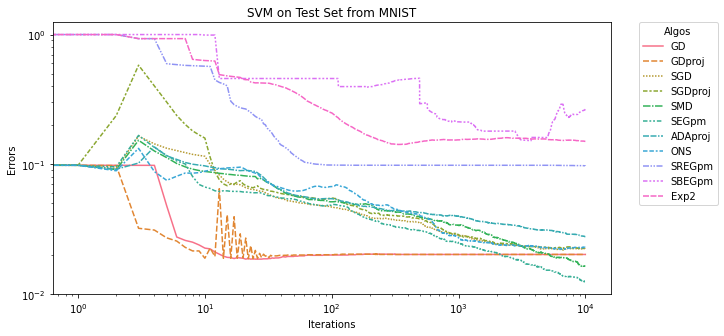

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 5))
ax = sns.lineplot(data=errors, linewidth=1.5,legend=False)
ax.set(xlabel='Iterations', 
       ylabel='Errors', 
       title='SVM on Test Set from MNIST', 
       xticks=[1, 10, 100, 1000, 10000],
       yticks=[0.01,0.02,0.05,0.1,0.2,0.5,1.],
       )
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(title='Algos', title_fontsize = 13,loc = 'best',
          labels=["GD","GDproj","SGD" ,"SGDproj", "SMD", "SEGpm" ,"ADAproj", "ONS", "SREGpm","SBEGpm","Exp2","ADAproj_PD","ADAproj_FBS","ADA_PD2","ADA_FBS2"])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
           title='Algos',
          labels=["GD","GDproj","SGD" ,"SGDproj", "SMD", "SEGpm" ,"ADAproj", "ONS", "SREGpm","SBEGpm","Exp2","ADAproj_PD","ADAproj_FBS","ADA_PD2","ADA_FBS2"])
plt.show()

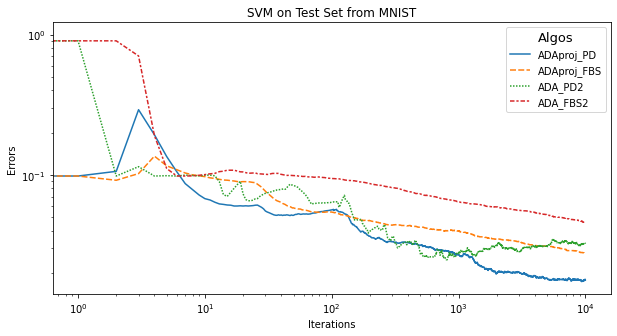

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 5))
ax = sns.lineplot(data=errors, linewidth=1.5,legend=False)
ax.set(xlabel='Iterations', 
       ylabel='Errors', 
       title='SVM on Test Set from MNIST', 
       xticks=[1, 10, 100, 1000, 10000],
       yticks=[0.01,0.02,0.05,0.1,0.2,0.5,1.],
       )
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(title='Algos', title_fontsize = 13,loc = 'upper right',
          labels=["ADAproj_PD","ADAproj_FBS","ADA_PD2","ADA_FBS2"])
plt.show()

In [ ]:
for err,name in zip(errors,names):
  print(name+'-> min : ', np.min(err), ' | last : ',err[-1])

GD-> min :  0.01849999999999996  | last :  0.020100000000000007
GDproj-> min :  0.01859999999999995  | last :  0.020100000000000007
SGD-> min :  0.02180000000000004  | last :  0.02210000000000001
SGDproj-> min :  0.022299999999999986  | last :  0.022399999999999975
SMD-> min :  0.01629999999999998  | last :  0.01639999999999997
SEGpm-> min :  0.012399999999999967  | last :  0.012399999999999967
ADAproj-> min :  0.027599999999999958  | last :  0.027599999999999958
ONS-> min :  0.02200000000000002  | last :  0.022700000000000053
SREGpm-> min :  0.09699999999999998  | last :  0.09699999999999998
Exp2-> min :  0.09430000000000005  | last :  0.17059999999999997
ADAproj_PD-> min :  0.017299999999999982  | last :  0.01770000000000005
ADAproj_FBS-> min :  0.027599999999999958  | last :  0.027599999999999958
ADA_PD2-> min :  0.024800000000000044  | last :  0.032399999999999984
ADA_FBS2-> min :  0.045599999999999974  | last :  0.045599999999999974
